# Problem 1

The dataset faces.mat contains a dataset of images, each $32\times 32$ in grayscale. We will perform PCA on this dataset.

1. Load the data use scipy.io.loadmat. Get the feature matrix. Each row of the feature matrix is an image. Plot the first 100 images, using subplot to make a 10 by 10 image matrix. Do you see some familiar faces? (Hint: recall how we plot images for the MNIST dataset. Use cmap=mpl.cm.gist_gray. If you see the image is rotated, set the "order" variable when you reshape the data. Also make the figure bigger if needed use rcParams as we did before.) 

2. Scale the feature matrix first. Perform a PCA for the scaled feature matrix to get all of the principal components. Plot the first 36 principal components in a 6 by 6 image matrix.

3. To have $95\%$ of the variance explained, what is the minimum number of principal components that are needed?

4. Build a PCA with 100 principal components. Project the data to the 100 principal components and perform an inverse transform back to the original dimension. Plot the first 100 images (10 by 10 image matrix) using the scaled feature matrix, and then plot the first 100 images using the recovered data. What do you see?

In [106]:
import numpy as np 
from sklearn.decomposition import PCA
import scipy.io as sio
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from scipy.stats import uniform

In [2]:
# Part 1.1
%cd /Users/AM/Documents/_CU Masters/2021 spr Python ML_5027/ML_py_code/hw_data
f = sio.loadmat('faces.mat')
X = f['X']

/Users/AM/Documents/_CU Masters/2021 spr Python ML_5027/ML_py_code/hw_data


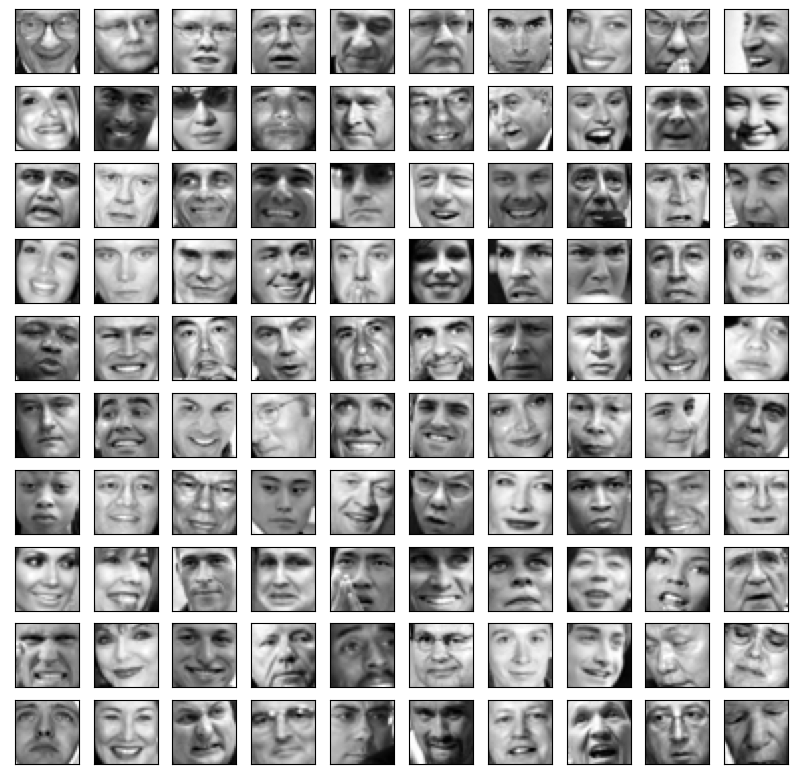

In [3]:
plt.figure(figsize=(10, 10), dpi=100)

for i in range(100):
    digit_image = X[i,:].reshape((32,32), order = 'F')
    plt.subplot(10,10,i+1)
    plt.imshow(digit_image, cmap = mpl.cm.gist_gray)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

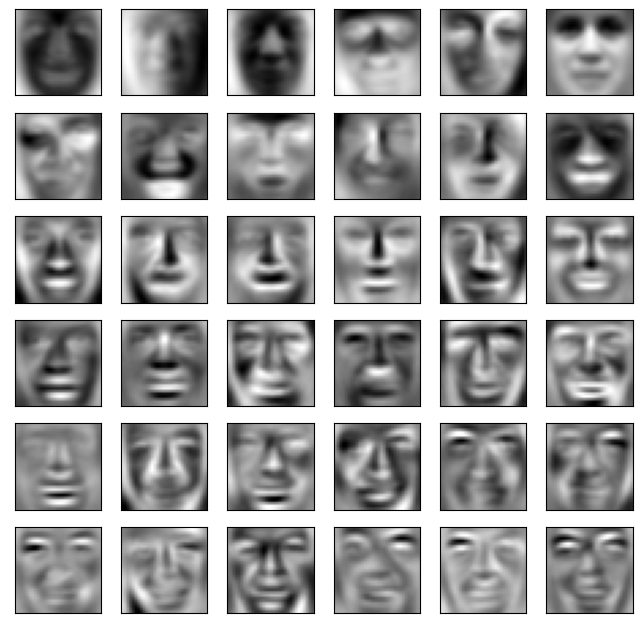

In [4]:
# Part 1.2
scaler = StandardScaler()
Xs = scaler.fit_transform(X)
pca = PCA()
pca.fit(Xs)
plt.figure(figsize=(8, 8), dpi=100)
for i in range(36):
    digit_image = pca.components_[i,:].reshape((32,32), order = 'F')
    plt.subplot(6,6,i+1)
    plt.imshow(digit_image, cmap = mpl.cm.gist_gray)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

the minimum number of principal components needed to explain 95%  of the variance is 130


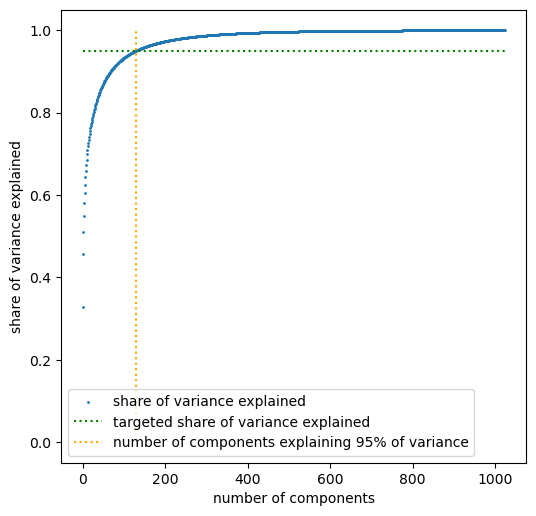

In [5]:
# part 1.3
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
print(f'the minimum number of principal components needed to explain 95%  of the variance is {d}')
plt.figure(figsize=(6, 6), dpi=100)

plt.scatter([i for i in range(len(pca.explained_variance_ratio_))], 
            np.cumsum(pca.explained_variance_ratio_), s = 1,
           label = "share of variance explained")
plt.hlines(y = .95, xmin=0, xmax=1024, colors='green', 
           linestyles='dotted', label="targeted share of variance explained")
plt.vlines(x = d, ymin=0, ymax=1, colors='orange', 
           linestyles='dotted', label="number of components explaining 95% of variance")
plt.xlabel('number of components')
plt.ylabel('share of variance explained')
plt.legend()
plt.show()

In [6]:
# Part 1.4
pca1 = PCA(n_components=100)
pca1.fit(Xs)
Xs_reduced = pca1.transform(Xs)
Xs_recovered = pca1.inverse_transform(Xs_reduced)

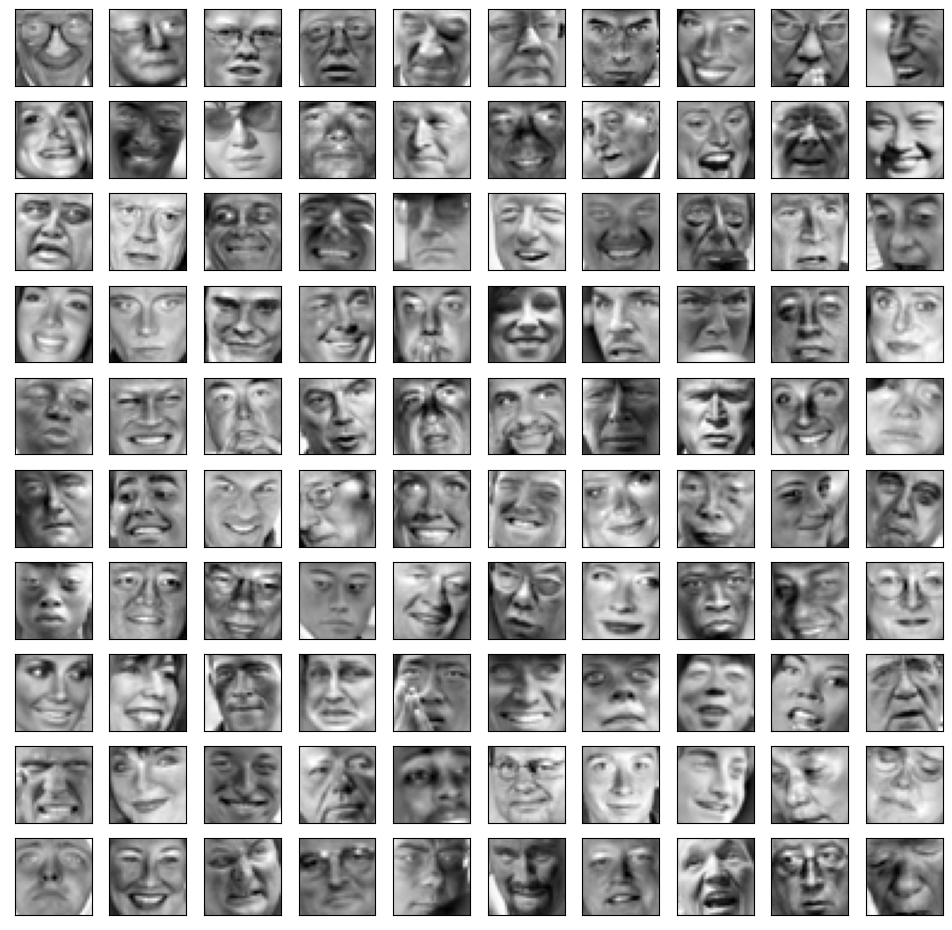

In [7]:
# scaled original
plt.figure(figsize=(12, 12), dpi=100)
for i in range(100):
    digit_image = Xs[i,:].reshape((32,32), order = 'F')
    plt.subplot(10,10,i+1)
    plt.imshow(digit_image, cmap = mpl.cm.gist_gray)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

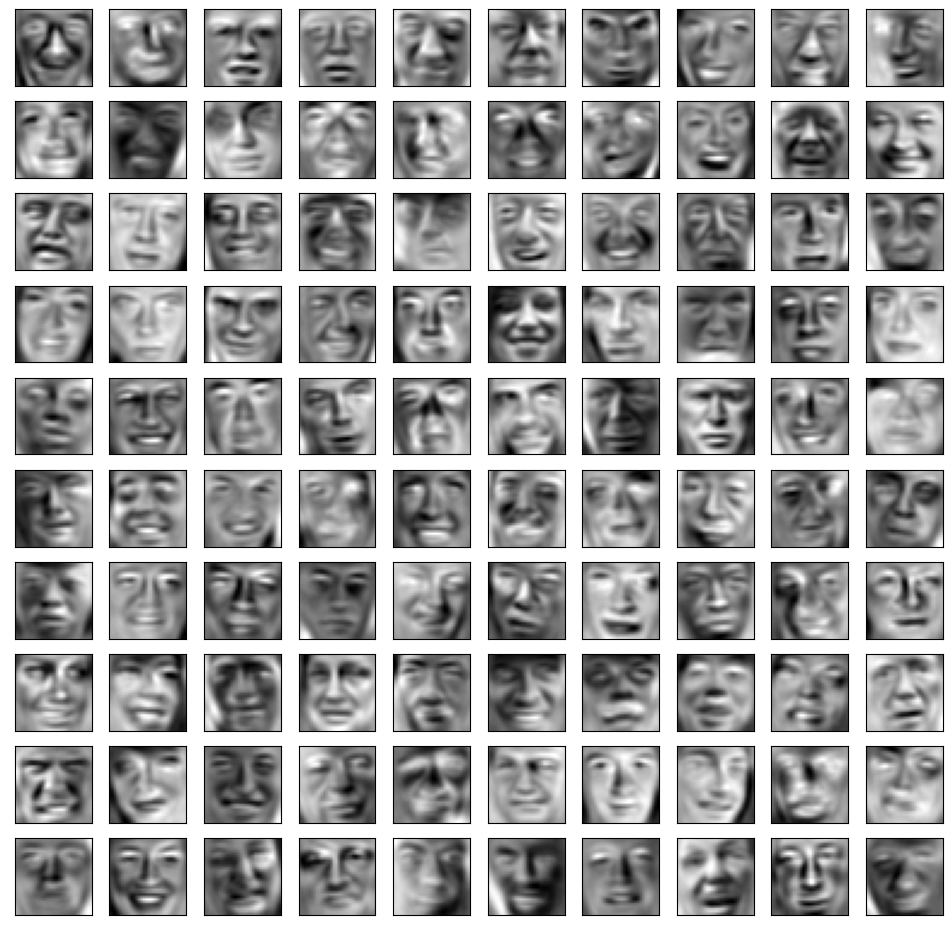

In [8]:
#recovered and still scaled
plt.figure(figsize=(12, 12), dpi=100)
for i in range(100):
    digit_image = Xs_recovered[i,:].reshape((32,32), order = 'F')
    plt.subplot(10,10,i+1)
    plt.imshow(digit_image, cmap = mpl.cm.gist_gray)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

We see that the inverse transformation based on only ~10% of features produces roughly recognizable faces (i.e. very close to the scaled originals).

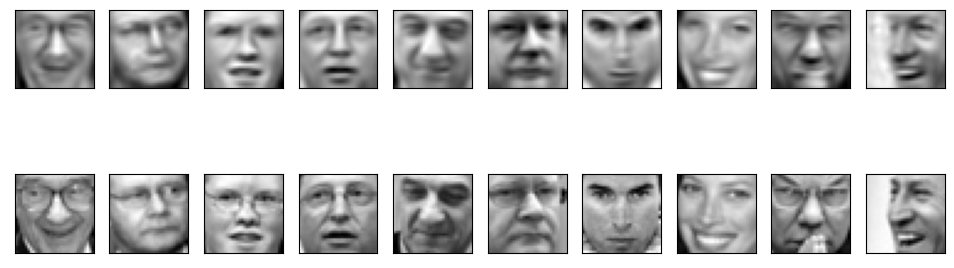

In [9]:
# Part extra 
# recovered and unscaled (the first row) vs. unscaled original (the second row)
X_recovered = scaler.inverse_transform(Xs_recovered)

plt.figure(figsize=(12,4), dpi =100)
for i in range(10):
    digit_image = X_recovered[i,:].reshape((32,32), order = 'F')
    plt.subplot(2,10,i+1)
    plt.imshow(digit_image, cmap = mpl.cm.gist_gray)
    
for i in range(10):
    digit_image = X[i,:].reshape((32,32), order = 'F')
    plt.subplot(2,10,i+11)
    plt.imshow(digit_image, cmap = mpl.cm.gist_gray)
plt.setp(plt.gcf().get_axes(), xticks=[], yticks=[]);
plt.show()

# Problem 2

Revisit Problem 2 HW 3. Read in the dataset stored in 'HW3P2.txt'. The first two columns represent two features, and the last column is the labels (0 and 1).

(a) Try a Support Vector Machine classifier (sklearn.svm.SVC), with various hyperparameters: kernel="linear", C in the range of 1 and 100 with 50 equidistant points; and kernel="rbf", C in the range of 1 and 100 with 50 equidistant points, and gamma in the range of 0.0001 and 2 with 50 equidistant points. Show the best parameters and best mean test score. In SVC, set random_state to 10.

(b) Make a decision boundary plot with the best parameters from (a)

(c) Use a randomized search to repeat Part (a), but use 1000 randomly chosen parameter combinations

(d) Compare the best mean test scores in (a) and (c). Are they close or very different?

In [126]:
class HW3_Problem:

    def __init__(self, file_name):
        self.df_unscaled = np.loadtxt(file_name, delimiter=' ')
        self.y = self.df_unscaled[:,2]
        self.scaler = StandardScaler()
        self.X = self.scaler.fit_transform(self.df_unscaled[:,[0,1]])
        self.svm = svm.SVC(random_state=10, kernel='rbf')
        
        self.tuned_parameters = [{'kernel': ['linear'],
                             'C': np.linspace(1, 100, 50)},
                            {'kernel': ['rbf'],
                             'C': np.linspace(1, 100, 50),
                            'gamma': np.linspace(0.0001, 2, 50)}]
    
    def grid_search(self, scoring = None):   
        
        self.clf_grid = GridSearchCV(
            self.svm, 
            self.tuned_parameters, 
            scoring=scoring)
        
        self.clf_grid.fit(self.X, self.y)
        
    
    def random_search(self, scoring = None):
        dist = [{'kernel': ['linear'], 'C': uniform(loc = 1, scale = 99)}, 
                {'kernel': ['rbf'],
                 'C': uniform(loc = 1, scale = 99),
                 'gamma': uniform(loc = 0.0001, scale = 1.999)}]
        
        self.clf_random = RandomizedSearchCV(self.svm, dist, n_iter = 1000)
        self.clf_random.fit(self.X, self.y)

    
    def plot_svc_decision_boundary(self, model): # based on https://scikit-learn.org/stable/auto_examples/svm/plot_svm_nonlinear.html#sphx-glr-auto-examples-svm-plot-svm-nonlinear-py
        plt.figure(figsize=(5.5, 5.5), dpi=100, facecolor='w', edgecolor='k')
        #xx, yy = np.meshgrid(np.linspace(0, 1.05, 500), np.linspace(0.35, 1.05, 500))
        xx, yy = np.meshgrid(np.linspace(self.df_unscaled[:,0].min(), self.df_unscaled[:,0].max(), 700), 
                             np.linspace(self.df_unscaled[:,1].min(), self.df_unscaled[:,1].max(), 700))

        Z = model.decision_function(self.scaler.transform(np.c_[xx.ravel(), yy.ravel()]))
        Z = Z.reshape(xx.shape)
        plt.imshow(Z, interpolation='nearest', 
                   extent=(xx.min(), xx.max(), yy.min(), yy.max()), aspect='auto',
                   origin='lower', cmap=plt.cm.RdYlGn)
        contours = plt.contour(xx, yy, Z, levels=[0], linewidths=1, linestyles='dashed')
        plt.scatter(self.df_unscaled[:, 0], self.df_unscaled[:, 1], s=25, c=self.df_unscaled[:,2], cmap=plt.cm.RdYlGn, edgecolors='k')
        

    

In [127]:
c = HW3_Problem('HW3P2.txt')

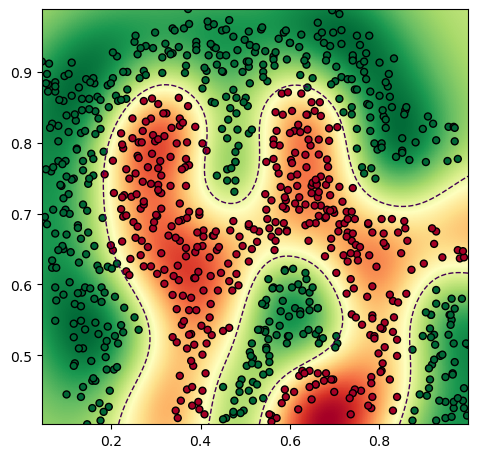

In [130]:
c.grid_search()
c.plot_svc_decision_boundary(c.clf_grid.best_estimator_)

In [131]:
c.clf_grid.best_estimator_, c.clf_grid.best_score_

(SVC(C=7.061224489795918, gamma=2.0, random_state=10), 0.8571044495227854)

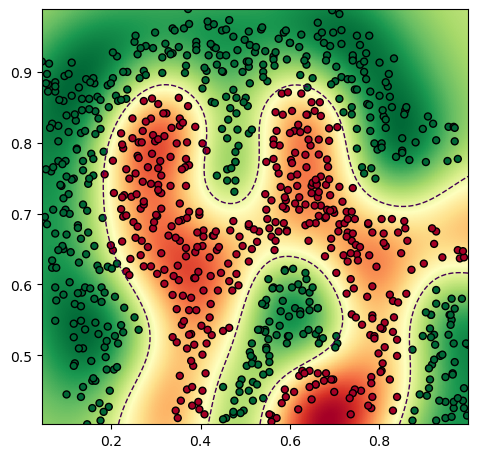

In [128]:
c.random_search()
c.plot_svc_decision_boundary(c.clf_random.best_estimator_)

In [129]:
c.clf_random.best_estimator_, c.clf_random.best_score_

(SVC(C=6.794037584643133, gamma=1.9548770986952069, random_state=10),
 0.8559416588251109)

the best mean test scores in (a) and (c) are very close (though the grid search gives a slightly better results)

In [132]:
print(f'for grid search the best mean test scores is: {c.clf_grid.best_score_}')
print(f'for random search the best mean test scores is: {c.clf_random.best_score_}')

for grid search the best mean test scores is: 0.8571044495227854
for random search the best mean test scores is: 0.8559416588251109
